# Setup

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphs/plotting
import seaborn as sns

In [8]:
#Check to ensure that both CSV files are present in the right directory

import os
for dirname, _, filenames in os.walk("/home/thomas/gitrepo/InsuranceAnalysis/data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/thomas/gitrepo/InsuranceAnalysis/data/freMTPLfreq.csv
/home/thomas/gitrepo/InsuranceAnalysis/data/.ipynb_checkpoints/freMTPLfreq-checkpoint.csv


# Step 1: Importing the datasets into dataframes, performing a merge a join and initial exploration

In [27]:
MTPL_freq = pd.read_csv("data/freMTPLfreq.csv")
MTPL_sev = pd.read_csv("data/freMTPLsev.csv")
MTPL_freq.value_counts()

PolicyID  ClaimNb  Exposure  Power  CarAge  DriverAge  Brand                               Gas      Region         Density
1         0        0.09000   g      0       46         Japanese (except Nissan) or Korean  Diesel   Aquitaine      76         1
275444    0        1.00000   d      11      45         Renault, Nissan or Citroen          Regular  Centre         10         1
275454    0        1.00000   e      5       32         Opel, General Motors or Ford        Regular  Centre         754        1
275453    0        0.32000   f      3       64         Renault, Nissan or Citroen          Regular  Centre         4116       1
275452    0        0.10000   e      2       29         Renault, Nissan or Citroen          Diesel   Centre         4116       1
                                                                                                                             ..
137721    0        0.60000   o      1       37         Japanese (except Nissan) or Korean  Diesel   Ile-de-Fr

In [55]:
#Total number of claims
print(sum(MTPL_sev["ClaimAmount"]))

34465077


In [32]:
MTPL_sev.value_counts()

PolicyID  ClaimAmount
43357     1169           2
33        302            1
250984    342            1
250836    1159           1
250837    1212           1
                        ..
110150    358            1
110176    1758           1
110211    1162           1
110214    1081           1
412944    10482          1
Length: 16180, dtype: int64

Total Amount Claimed

As gathered by the value_counts() function, the PolicyID variable is unique to each policy. So there can't be two policies with the same policyID. With the exception of 43357, which we will investigate

In [36]:
result = MTPL_sev[MTPL_sev["PolicyID"] == 43357]
result

,PolicyID,ClaimAmount
2455,43357,1169
2491,43357,1169


We are presented with a duplicate entry. Investigating any further occurances of duplicates

In [37]:
duplicates_sev = MTPL_sev[MTPL_sev.duplicated(["PolicyID"], keep =False)]
duplicates_sev

,PolicyID,ClaimAmount
4,309380,55077
5,309380,7593
23,309894,1182
26,319926,285
27,319926,555
...,...,...
16118,208591,488
16119,217050,676
16139,215642,244
16172,304172,281


1548 occurances of duplicates inside MTPL_sev. We don't want duplicates in our analysis, so We will use the groupby/aggregate function in the next step to get rid of the duplicate entries

In [39]:
duplicates_freq = MTPL_freq[MTPL_freq.duplicated(["PolicyID"], keep =False)]
duplicates_freq

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density


No such duplicates appear in duplicates_freq



## Getting rid of duplicates

In [40]:
#Aggregate the claim amount of PolicyID
MTPLsev_grp = MTPL_sev.groupby(["PolicyID"])[["ClaimAmount"]].agg("sum").reset_index()
MTPLsev_grp.head(5)

,PolicyID,ClaimAmount
0,33,302
1,41,2001
2,92,1449
3,96,10870
4,142,1390


Duplicates are now gone

### Merging

In [48]:
df_merged = pd.merge(MTPL_freq, MTPLsev_grp, how = "outer", on="PolicyID").fillna(0).set_index("PolicyID")

Merging the two datasets, as MTPL_sev contains only one additional column and had a convinient PolicyID key that we can merge on and set it as index

In [47]:
df_merged

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
PolicyID,,,,,,,,,,
1,0,0.090000,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,0,0.840000,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
3,0,0.520000,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,0,0.450000,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
5,0,0.150000,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0
...,...,...,...,...,...,...,...,...,...,...
413165,0,0.002740,j,0,29,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,2471,0.0
413166,0,0.005479,d,0,29,Japanese (except Nissan) or Korean,Regular,Ile-de-France,5360,0.0
413167,0,0.005479,k,0,49,Japanese (except Nissan) or Korean,Diesel,Ile-de-France,5360,0.0


In [49]:
print(sum(df_merged['ClaimAmount']))

34465077.0


### 1.1 Initial exploration

In [50]:
print(df_merged.columns)
print('\n')
print(df_merged.dtypes)
print('\n')

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas',
       'Region', 'Density', 'ClaimAmount'],
      dtype='object')


ClaimNb          int64
Exposure       float64
Power           object
CarAge           int64
DriverAge        int64
Brand           object
Gas             object
Region          object
Density          int64
ClaimAmount    float64
dtype: object




In [52]:
print(df_merged.head())

          ClaimNb  Exposure Power  CarAge  DriverAge  \
PolicyID                                               
1               0      0.09     g       0         46   
2               0      0.84     g       0         46   
3               0      0.52     f       2         38   
4               0      0.45     f       2         38   
5               0      0.15     g       0         41   

                                       Brand      Gas              Region  \
PolicyID                                                                    
1         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
2         Japanese (except Nissan) or Korean   Diesel           Aquitaine   
3         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
4         Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais   
5         Japanese (except Nissan) or Korean   Diesel    Pays-de-la-Loire   

          Density  ClaimAmount  
PolicyID                        
1

### Broad questions: outliers, max, most common occurances

Our Sales department asked us to outline the percentage of clients who have not made any claims

In [59]:
policies_no_claims = len(df_merged.loc[df_merged["ClaimNb"] == 0].index)
all_policies = len(df_merged.index)

pct_policies_no_claim = round((policies_no_claims/all_policies)*100, 2)

print(str(pct_policies_no_claim)+ "% of policyholders have not made any claims")

96.28% of policyholders have not made any claims


And the number of those who did:

In [68]:
print(str(round(100 - pct_policies_no_claim, 2)) + "% of policyholders have made at least one claim")

3.72% of policyholders have made at least one claim


Since most policyholders haven't filed any claims, it suggests that the distribution of ClaimAmounts will be such that there is a peak at zero, 
but the distribution will also be skewed to the right or have a long tail on the right-hand side. This is because there will be some policyholders 
who file claims with positive ClaimAmounts, and the probability of such claims decreases exponentially as the ClaimAmount increases.

## Step 2: Generating additional features based on interactions/transformations fo existing variables

Two additional indicators that our Sales Department has requested are: the frequency of claims and severity of claims (in units of public exposure

In [69]:
df_merged["ClaimFreq"] = df_merged["ClaimNb"] / df_merged["Exposure"]

df_merged["ClaimSev"] = df_merged["ClaimAmount"] / df_merged["Exposure"]

Examples:

In [ ]:
example1 = df_merged["ClaimFreq"]

## Step 3: Performing train/test slpit of the dataset

1. Separate df_merged into 2 datasets 

In [78]:
y_full = df_merged.ClaimAmount
X_full = df_merged.drop(["ClaimAmount", "ClaimSev"], axis=1)

# print(y_full.head())

# print(X_full.head())

In [80]:
from sklearn.model_selection import train_test_split

#80% train, 20% test
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size = 0.8, test_size = 0.2, random_state=1)

In [88]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the training/validation feature subsets to avoid changing any original data.
copy_X_train = X_train.copy()
copy_X_valid = X_valid.copy()

# Apply a label encoder to the 'Power' column (i.e. encoding of ordinal variable).
label_encoder = LabelEncoder()

copy_X_train['Power'] = label_encoder.fit_transform(X_train['Power'])
copy_X_valid['Power'] = label_encoder.transform(X_valid['Power'])

### One-Hot Encoding

In [90]:
from sklearn.preprocessing import OneHotEncoder

# Initialise a one-hot encoder to columns that contain categorical data.
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = ['Brand', 'Gas', 'Region']

## We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented
## in the training data, and setting sparse=False ensures that the encoded columns are returned as a numpy array
## (instead of a sparse matrix).

# Use the one-hot encoder to transform the categorical data columns. 
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(copy_X_train[OH_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(copy_X_valid[OH_cols]))

# One-hot encoding removes the index; re-assign the original index.
OH_cols_train.index = copy_X_train.index
OH_cols_valid.index = copy_X_valid.index

# Add column-labelling back in, using the get_feature_names() function. 
OH_cols_train.columns = OH_encoder.get_feature_names_out(OH_cols)
OH_cols_valid.columns = OH_encoder.get_feature_names_out(OH_cols)

# Create copies that only include numerical feature columns (these will be replaced with one-hot encoded versions).
copy_X_train_no_OH_cols = copy_X_train.drop(OH_cols, axis=1)
copy_X_valid_no_OH_cols = copy_X_valid.drop(OH_cols, axis=1)

# Concatenate the one-hot encoded columns with the existing numerical feature columns.
X_train_enc = pd.concat([copy_X_train_no_OH_cols, OH_cols_train], axis=1)
X_valid_enc = pd.concat([copy_X_valid_no_OH_cols, OH_cols_valid], axis=1)

/home/thomas/anaconda3/envs/DataAnalysis/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Data Scaling - normalisation

In [91]:
from sklearn.preprocessing import MinMaxScaler

Here we normalise our data, to ensure that when we train our regression model, all features will have variance with the same order of magnitude as each other. Thus, no single feature will domindate the objective function and prohibit
the model from earning from other features correctly as expected

In [93]:
MM_scaler = MinMaxScaler()
MM_scaler.fit(X_train_enc)

#Fitting scaler, then normalising both the training and validation feautre datasets
X_train_scale = pd.DataFrame(MM_scaler.transform(X_train_enc),
                             index = X_train_enc.index,
                             columns=X_train_enc.columns)

X_valid_scale = pd.DataFrame(MM_scaler.transform(X_valid_enc),
                             index = X_valid_enc.index, 
                             columns = X_valid_enc.columns)

In [95]:
#Verifying features
X_train_scale.min(axis=0).head(5)



ClaimNb      0.0
Exposure     0.0
Power        0.0
CarAge       0.0
DriverAge    0.0
dtype: float64

In [97]:
X_train_scale.max(axis=0).head(5)

ClaimNb      1.0
Exposure     1.0
Power        1.0
CarAge       1.0
DriverAge    1.0
dtype: float64

In [98]:
X_valid_scale.max(axis=0).head(5)

ClaimNb      1.000000
Exposure     0.718206
Power        1.000000
CarAge       1.000000
DriverAge    1.000000
dtype: float64

In [99]:
X_valid_scale.min(axis=0).head(5)

ClaimNb      0.0
Exposure     0.0
Power        0.0
CarAge       0.0
DriverAge    0.0
dtype: float64

### Step 4: Exploring the original dataset to obtain descriptive statistics

In [100]:
print(df_merged.describe())

             ClaimNb       Exposure         CarAge      DriverAge  \
count  413169.000000  413169.000000  413169.000000  413169.000000   
mean        0.039163       0.561088       7.532404      45.319876   
std         0.204053       0.369477       5.763011      14.328120   
min         0.000000       0.002732       0.000000      18.000000   
25%         0.000000       0.200000       3.000000      34.000000   
50%         0.000000       0.540000       7.000000      44.000000   
75%         0.000000       1.000000      12.000000      54.000000   
max         4.000000       1.990000     100.000000      99.000000   

             Density   ClaimAmount      ClaimFreq      ClaimSev  
count  413169.000000  4.131690e+05  413169.000000  4.131690e+05  
mean     1985.153913  8.341642e+01       0.118803  3.711403e+02  
std      4776.254543  4.192526e+03       2.155181  3.493029e+04  
min         2.000000  0.000000e+00       0.000000  0.000000e+00  
25%        67.000000  0.000000e+00       0.00000

In [101]:
desc_pairplot_x_vars_A = ['ClaimNb', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']

desc_pairplot_x_vars_B = ['Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Density']

Variables being passed into sns.pairplot (full_dataset, defined above (x_axis), single variable (y_axis)

#### Expsoure vs all

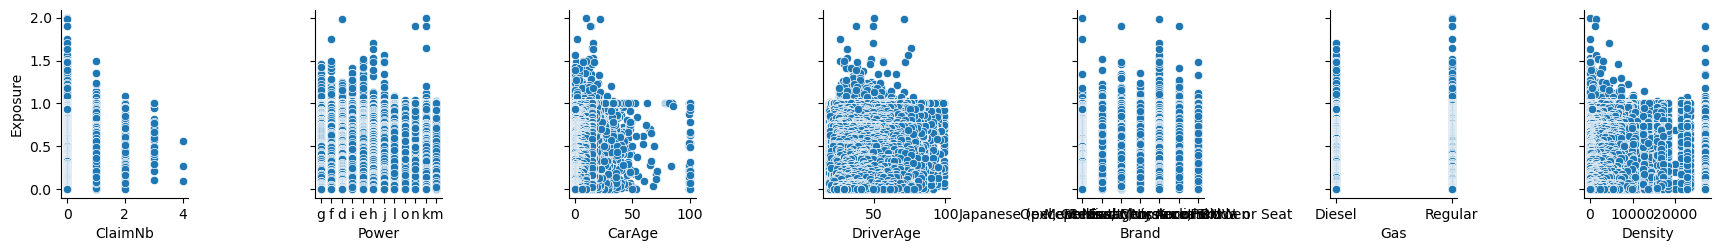

In [102]:
desc_pairplot_1 = sns.pairplot(df_merged, x_vars = desc_pairplot_x_vars_A, y_vars="Exposure")

Breakdown:
1. ClaimNb - Policyholders with higher claim  tend to be covered with policies with shorter Exposure
2. Power - Cars with less power tend to be have longer exposure period, although with some exceptions
3. CarAge - The newer the car, the longer the exposure period with some exceptions of vintage cars
4. DriverAge - No pattern of Exposure < 1, lack of really young drivers and really old drivers with Exposure > 1
5. Brand - No clear correlation
6. Gas - Regular gets slightly longer exposure periods then Diesel
7. Density - Wide distribution of policy exposure periods, which appears to decrease as the  population density of the area that the policy inhabits increases , however there are some observations at higher values of density

ClaimNb vs. x_vars.

#### ClaimNumber vs all

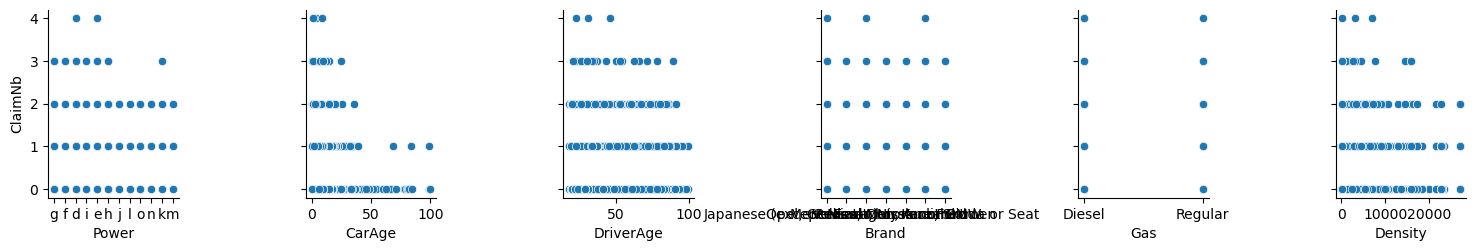

In [103]:
desc_pairplot_2 = sns.pairplot(df_merged, x_vars = desc_pairplot_x_vars_B, y_vars = "ClaimNb")

1. Power: The trend in this graph implies that policyholders who are in the upper quartile of claim frequency (i.e. N > 3) tend to drive less powerful/average cars, however there does not appear to be any general correlation between car power and claim frequency, among the majority of other policyholders.
2. CarAge: The trend in this graph implies that a majority of the variance in ClaimNb is shown across cars that are younger than 50; the number of claims per policyholder tends to decrease with the age of the car.
3. DriverAge: This graph shows a wide distribution of claim frequencies across drivers of different ages, with no clear trend between the age of the policyholder and the number of claims that they have made.
4. Brand: This graph does not show any clear correlation or trend between the number of claims made and the brand of the car owned by the (insured) policyholder.
5. Gas: This graph also does not show any clear correlation between the number of claims made and the fuel type of the car that is insured.
6. Density: This graph shows the general trend that the number of claims per policyholder decreases as the population density (of the town/city that they live in) increases.



#### ClaimFrequency vs all

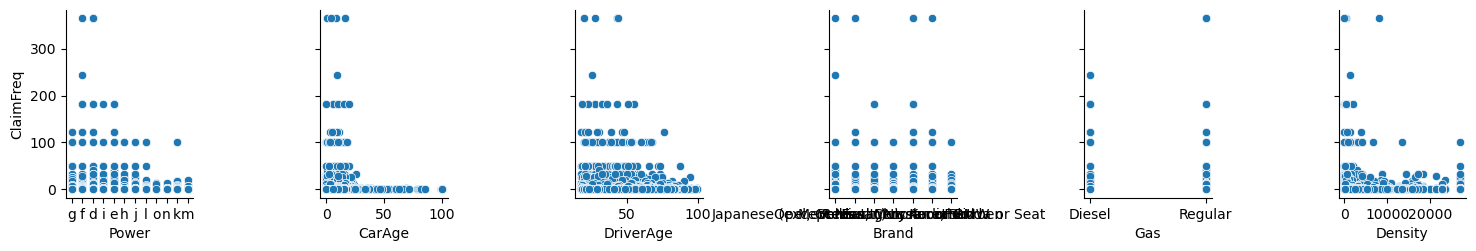

In [104]:
desc_pairplot_3 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimFreq')

1. Power: The trend in this graph implies that ClaimFreq tends to decrease as the power of the car increases, however there are also some small peaks in ClaimFreq for certain categories representing high-powered cars (e.g. k/l).
2. CarAge: This graph shows that a vast majority of the variance in ClaimFreq is shared across policyholders who own relatively young cars (CarAge < 25), but also implies that ClaimFreq decreases as the age of the car increases.
3. DriverAge: This graph shows that claim frequency also decreases as the age of the policyholder increases, however a vast majority of the variance in ClaimFreq can be captured between the values of 0-100 (across all driver ages).
4. Brand: There appears to be no clear trend or correlation between the frequency of claims and the brand of the car owned by the policyholder.
5. Gas: This graph also does not show any clear correlation between ClaimFreq and the fuel type of the policyholder's car.
6. Density: This graph displays a negative correlation between the frequency of claims made by the policyholder and the population density of the city that they live in.



#### ClaimAmount vs all

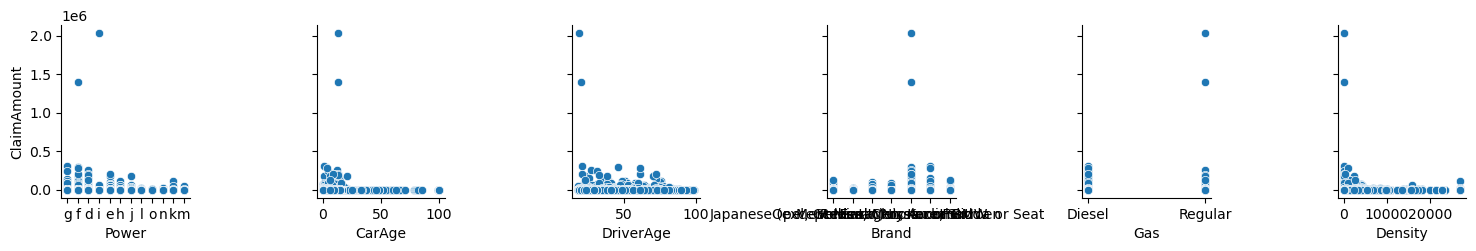

In [105]:
desc_pairplot_4 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimAmount')

1. Power: This graph shows that there is an overall negative correlation between the power of the car owned by the policyholder and the total value of claims made by them, however there are two major outliers at lower car powers - this is generally an exception to the rule.
2. CarAge: Similarly to the power of the car, there is an overall negative correlation between the age of the car and the total value of claims made by the policyholder, however there are some outliers for relatively new cars.
3. DriverAge: This graph shows that total claim amounts tend to be higher at younger ages (between 20-40), however there is also a smaller group of drivers between 60-80 that are responsible for non-trivial total claim amounts; major outliers can also be seen for two newer drivers (DriverAge ~ 20).
4. Brand: Whilst there are a handful of brands that are responsible for higher-than-normal claim amounts, these are in the vast minority of policyholders - the overall trend is that there is no clear correlation between the brand of the car and the total claim amount.
5. Gas: This graph also does not show any clear correlation between ClaimAmount and the fuel type of the policyholder's car, however there are two distinct outliers within the 'Regular' category.
6. Density: This graph displays a negative correlation between the total value of claims made by the policyholder and the population density of the city that they live in.



#### ClaimSeverity vs all

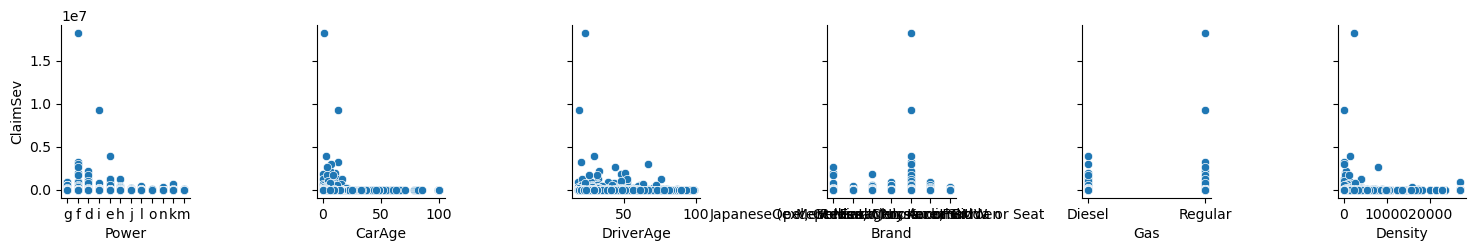

In [106]:
desc_pairplot_5 = sns.pairplot(df_merged, x_vars=desc_pairplot_x_vars_B, y_vars='ClaimSev')

1. Power: This graph shows that there is an overall negative correlation between the power of the car owned by the policyholder and the exposure-weighted total severity of claims made, however as before there are two major outliers at lower car powers.
2. CarAge: Similarly to the power of the car, there is an overall negative correlation between the age of the car and the exposure-weighted total severity of claims made by the policyholder, however there are some outliers for relatively new (albeit slightly used) cars.
3. DriverAge: This graph shows that exposure-weighted claim severities tend to be higher at younger ages (between 20-35), however there is also a smaller group of drivers between 45-55 that are responsible for non-trivial total claim amounts; some major outliers can also be seen for two very new drivers (DriverAge ~ 20).
4. Brand: Whilst there are a handful of brands that are responsible for higher-than-normal claim severities, these are in the vast minority of policyholders - the overall trend is that there is no clear correlation between the brand of the car and the total claim amount.
5. Gas: This graph also does not show any clear correlation between ClaimSeverity and the fuel type of the policyholder's car, however there are two distinct outliers within the 'Regular' category.
6. Density: This graph displays a negative correlation between the total value of claims made by the policyholder and the population density of the city that they live in.



MISC:

Linear Regression for Claim amount is not appropriated as values are centred around -

Consider Regression approaches using generalised linear models which allow for response variables to have distributions that are non-normal,
as well as other regressors that are capable of generalising in an agnostic manner

### Step 5: Perform feature selection via L1 regularisation


This is done to reduce the number of features that are used for fitting each of the models - to prevent overfitting

Loss=Error(y,y^)+λ∑i=1N|wi|

Where:
1. y is the true value/severity of the claim
2. y^ is the claim value/severity predicted by the model
3. λ>0 is the regularisation parameter that determines the strength of regularisation to be applied to the loss function
4. wi is the weight of feature i

Implemented via Lasso() from sklearn.linear_model

Takes 
1. Alpha - represntes the constant that multiples the L1 term (equivalent to λ) (multiplies the L1 term)
2. Random state - sets the random number seed and is used for reproducibility pruposes
3. max_iter 

#### Method:
1. Pass lasso to the SelectFromModel class, before assigning it to a new variable called model - 
we specify prefit=True to ensure that the meta-transformer should expect a prefit model to be passed directly to it.
2. Apply .Transform() method to reduce the scaled training dataset down to the features that were selected by the Lasso model
3. Finally, we create a new df selected_features which holds all important features from the original set of columns in X_train_L1 as their original values but sets values of 0 for every other feature

In [111]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Establish the Lasso (L1) Regularisation model that will perform feature selection.
lasso = Lasso(alpha=5e-5, random_state=1, max_iter=1000000).fit(X_train_scale, y_train)
model = SelectFromModel(lasso, prefit=True)

X_train_l1 = model.transform(X_train_scale)

selected_features = pd.DataFrame(model.inverse_transform(X_train_l1),
                                index=X_train_scale.index,
                                columns=X_train_scale.columns)

print(selected_features)

          ClaimNb  Exposure     Power  CarAge  DriverAge   Density  ClaimFreq  \
PolicyID                                                                        
194119       0.00  0.240163  0.181818    0.07   0.407407  0.152826   0.000000   
293687       0.00  0.501829  0.272727    0.13   0.358025  0.004667   0.000000   
132615       0.25  0.199907  0.090909    0.09   0.333333  1.000000   0.006849   
138539       0.00  0.290483  0.090909    0.04   0.172840  0.029632   0.000000   
217750       0.00  0.260291  0.181818    0.11   0.111111  0.018631   0.000000   
...           ...       ...       ...     ...        ...       ...        ...   
73350        0.00  0.501829  0.181818    0.09   0.567901  0.002630   0.000000   
371404       0.00  0.209971  0.545455    0.01   0.111111  1.000000   0.000000   
312202       0.00  0.189842  0.000000    0.01   0.481481  1.000000   0.000000   
267337       0.00  0.089202  0.000000    0.12   0.456790  0.005223   0.000000   
128038       0.00  0.501829 

/home/thomas/anaconda3/envs/DataAnalysis/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [112]:
selected_columns = selected_features.columns[selected_features.var() != 0]

print(selected_columns)

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Density',
       'ClaimFreq', 'Brand_Fiat', 'Brand_Japanese (except Nissan) or Korean',
       'Brand_Mercedes, Chrysler or BMW', 'Brand_Opel, General Motors or Ford',
       'Brand_Renault, Nissan or Citroen', 'Brand_other', 'Gas_Diesel',
       'Region_Aquitaine', 'Region_Basse-Normandie', 'Region_Bretagne',
       'Region_Centre', 'Region_Haute-Normandie', 'Region_Limousin',
       'Region_Nord-Pas-de-Calais', 'Region_Pays-de-la-Loire',
       'Region_Poitou-Charentes'],
      dtype='object')


In [113]:
X_train_L1reg = selected_features.drop(selected_features.columns[selected_features.var() == 0], axis = 1)

In [114]:
print(X_train_L1reg)

          ClaimNb  Exposure     Power  CarAge  DriverAge   Density  ClaimFreq  \
PolicyID                                                                        
194119       0.00  0.240163  0.181818    0.07   0.407407  0.152826   0.000000   
293687       0.00  0.501829  0.272727    0.13   0.358025  0.004667   0.000000   
132615       0.25  0.199907  0.090909    0.09   0.333333  1.000000   0.006849   
138539       0.00  0.290483  0.090909    0.04   0.172840  0.029632   0.000000   
217750       0.00  0.260291  0.181818    0.11   0.111111  0.018631   0.000000   
...           ...       ...       ...     ...        ...       ...        ...   
73350        0.00  0.501829  0.181818    0.09   0.567901  0.002630   0.000000   
371404       0.00  0.209971  0.545455    0.01   0.111111  1.000000   0.000000   
312202       0.00  0.189842  0.000000    0.01   0.481481  1.000000   0.000000   
267337       0.00  0.089202  0.000000    0.12   0.456790  0.005223   0.000000   
128038       0.00  0.501829 

In [115]:
X_valid_L1reg = X_valid_scale[selected_columns]

## Regressors/models

In [ ]:
Aim: predict ClaimAmount

Approaches:
1. Random Forest Regression
2. Poisson Regression - assumes ClaimAmount has Poisson distribution
3. Tweedie Regression - assums ClaimAmount has Tweedie distribution
4. XGBoost Regression - reducing error gradually 


## Cross-Validation to obtain the optimal set of hyperparameters

RandomForestRegressor

    n_estimators represents the number of decision trees that are implemented by the random forest regressor. We will aim to optimise this hyperparameter.
    random_state sets the random number seed and is used for reproducibility purposes. Here, we set this value to 1.
    n_jobs represents the number of calculations to run in parallel; setting a value of -1 means that all processors will be used.


PoissonRegressor

    alpha represents the constants that multiplies the penalty term, thus determining the strength of regularisation for the Poisson GLM used. We will aim to optimise this hyperparameter.
    max_iter represents the maximal number of iterations for the PoissonRegressor's solver.


TweedieRegressor

    power determines the underlying target value's distribution - using a value between 1 and 2 produces a compound Poisson-Gamma distribution.

    As a pure Gamma distribution's probability density is not defined at x=0, we set this value to 1.8 such that the target's compound distribution shows more Gamma form than Poisson. This is another hyperparameter that could potentially be optimised for simultaneously, via grid-search methods.

    alpha represents the constants that multiplies the penalty term, thus determining the strength of regularisation for the Tweedie GLM used. We will aim to optimise this hyperparameter.
    max_iter represents the maximal number of iterations for the TweedieRegressor's solver.


In [118]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor

# Import the cross_val_score function from sklearn.
from sklearn.model_selection import cross_val_score


In [119]:
results_RF = {}
results_PGLM = {}
results_TGLM = {}
results_XGB = {}

In [120]:
def get_score_RF(n_estimators):
    model_RF = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    
    scores_RF = -1 * cross_val_score(model_RF, X_train_L1reg, y_train,
                              cv=5,
                              scoring='neg_mean_absolute_error')

    return scores_RF.mean()

def get_score_PGLM(alpha):
    model_PGLM = PoissonRegressor(alpha=alpha, max_iter=500)
    
    scores_PGLM = -1 * cross_val_score(model_PGLM, X_train_L1reg, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    
    return scores_PGLM.mean()

def get_score_TGLM(alpha):
    model_TGLM = TweedieRegressor(power=1.8, alpha=alpha, max_iter=500)
    
    scores_TGLM = -1 * cross_val_score(model_TGLM, X_train_L1reg, y_train,
                                  cv=5,
                                  scoring='neg_mean_absolute_error')
    
    return scores_TGLM.mean()

def get_score_XGB(n_estimators):
    model_XGB = XGBRegressor(n_estimators=n_estimators,
                               learning_rate=0.01,
                               random_state=1)
    
    scores_XGB = -1 * cross_val_score(model_XGB, X_train_L1reg, y_train,
                                     cv=5,
                                     scoring='neg_mean_absolute_error')
    
    return scores_XGB.mean()

In [121]:
for i in range(1, 9):
    results_RF[100*i] = get_score_RF(100*i)
    print("results_RF{} recorded".format(i))

print("RF done")

results_RF1 recorded
results_RF2 recorded
results_RF3 recorded
results_RF4 recorded
results_RF5 recorded
results_RF6 recorded
results_RF7 recorded
results_RF8 recorded
RF done


In [122]:
for i in range(1, 9):
    results_PGLM[round(0.2*i, 2)] = get_score_PGLM(round(0.2*i, 2))
    print("results_PGLM{} recorded".format(i))

print("PGLM done")

results_PGLM1 recorded
results_PGLM2 recorded
results_PGLM3 recorded
results_PGLM4 recorded
results_PGLM5 recorded
results_PGLM6 recorded
results_PGLM7 recorded
results_PGLM8 recorded
PGLM done


In [123]:
for i in range(1, 9):
    results_TGLM[round(0.01*i, 2)] = get_score_TGLM(round(0.01*i, 2))
    print("results_TGLM{} recorded".format(i))

print("TGLM done")


results_TGLM1 recorded
results_TGLM2 recorded
results_TGLM3 recorded
results_TGLM4 recorded
results_TGLM5 recorded
results_TGLM6 recorded
results_TGLM7 recorded
results_TGLM8 recorded
TGLM done


In [124]:
for i in range(1, 9):
    results_XGB[5*i] = get_score_XGB(5*i)
    print("results_XGB{} recorded".format(i))
    
print("XGB done")


results_XGB1 recorded
results_XGB2 recorded
results_XGB3 recorded
results_XGB4 recorded
results_XGB5 recorded
results_XGB6 recorded
results_XGB7 recorded
results_XGB8 recorded
XGB done


### Determining the optimal hyperparameters

In [125]:
RF_n_estimators_best = min(results_RF, key=results_RF.get)
print(RF_n_estimators_best)

700


In [126]:
PGLM_alpha_best = min(results_PGLM, key=results_PGLM.get)
print(PGLM_alpha_best)

0.8


In [127]:
TGLM_alpha_best = min(results_TGLM, key=results_TGLM.get)
print(TGLM_alpha_best)

0.04


In [128]:
XGB_n_estimators_best = min(results_XGB, key=results_XGB.get)
print(XGB_n_estimators_best)

40


### Train (fit) the models to the entire training dataset

In [129]:
model_RF_opt = RandomForestRegressor(n_estimators=RF_n_estimators_best, random_state=1, n_jobs=-1)

model_PGLM_opt = PoissonRegressor(alpha=PGLM_alpha_best, max_iter=500)

model_TGLM_opt = TweedieRegressor(power=1.8, alpha=TGLM_alpha_best, max_iter=500)

model_XGB_opt = XGBRegressor(n_estimators=XGB_n_estimators_best, learning_rate=0.01, random_state=1)

In [130]:
model_RF_opt.fit(X_train_L1reg, y_train)
print("model_RF_opt trained")

model_PGLM_opt.fit(X_train_L1reg, y_train)
print("model_PGLM_opt trained")

model_TGLM_opt.fit(X_train_L1reg, y_train)
print("model_TGLM_opt trained")

model_XGB_opt.fit(X_train_L1reg, y_train)
print("model_XGB_opt trained")

model_RF_opt trained
model_PGLM_opt trained
model_TGLM_opt trained
model_XGB_opt trained


### Generating a unique set of predictions for each model

In [134]:
preds_RF = model_RF_opt.predict(X_valid_L1reg)
preds_PGLM = model_PGLM_opt.predict(X_valid_L1reg)
preds_TGLM = model_TGLM_opt.predict(X_valid_L1reg)
preds_XGB = model_XGB_opt.predict(X_valid_L1reg)
print("All predictions generated")

All predictions generated


## Model performance using validation data

The 2 options we have are: 
MAE (Mean Absolute Error)
RMSE (Root Mean Squared Error)

Calculating RMSE involves squaring each prediction error, which is not optimal in our case as only 3% of all the data is non-zero 
therefore put exagurated importance on that 3% and the vast majority (96%) will get heavily penalised 

We will use MAE from sklearn.metrics instead.



In [135]:
from sklearn.metrics import mean_absolute_error

MAE_RF = mean_absolute_error(y_valid, preds_RF)
MAE_PGLM = mean_absolute_error(y_valid, preds_PGLM)
MAE_TGLM = mean_absolute_error(y_valid, preds_TGLM)
MAE_XGB = mean_absolute_error(y_valid, preds_XGB)
print("All MAE scores calculated")

All MAE scores calculated


In [136]:
MAE_results = {'RF': MAE_RF,
                'PGLM': MAE_PGLM,
                'TGLM': MAE_TGLM,
                'XGB': MAE_XGB}

print(MAE_results)

{'RF': 95.01813166443816, 'PGLM': 119.47557730348673, 'TGLM': 77.99906852382645, 'XGB': 57.404240598175434}


In [137]:
best_model = min(MAE_results, key=MAE_results.get)
print(best_model)

XGB


Notes for further improvement:
Iteratively refine the model chosen above by continually re-training it such that an optimal fit to test data is achieved

### Review for areas of improvement

For example, in terms of the approach teaken to model/predict claim severity:
1. In this project, we only considered determining the total loss amount per policyholder based on their risk characteristics,
and didnot determine the average loss amount per claim. it may be possible to model this alternate scenario by deriving additional features beforehard
eg. max & min ClaimAmounts per policyholder
2. We used the nubmer of claims that was provided within the training_test dataset rather than genarting our own predicitons beforehand 
(i.e.we have skipped the first step in the frequency-severity method of modelling losses) -furthermore, tradtionally we only wish to oreduct the total loss
for policyholders who are expected to  make at least 1 claim. As a result, we would only need to use non-zero claim amounts for model training/testing purposes
Therefore we could have used Gamma-based GLM in comparison to Tweedie-based GLM instead of Poisson regresor
3. Trained data only once (Cross-validation) and tested only once


Data pre-processing:
1. Better alternatives for hot-encoding
eg. We have used one-hot encoding on Gas, Brand, Region, each of these varied in cordinality - using one-hot encoding is generally not recommended for categories of high cardinality (eg. Region)

Hyperparameter optimisation:
1. Perform hyperparameter optimisation via grid-seach methods, in order to iterate through all parameter values with global minimum of its hyperdimensional loss function surface
instead of optimising a single parameter whilst holding all other parameters constsant as shown earlier above. Result: optmised set of models that correspond
with the global minima of their respective loss surfaces
2. GridSeachCV() with sklearn.model_selection:
 2.1 estimator - model name
     param_grid - dictionary of param names/settings
     scoring - scoring method that we wish to use n order to measure the perforamnce of each model iteration for each set of hyperparameters for example (neg_mean_absolute_error)

Feature Selection
1. More stingent feature selection could be performed in order to further reduce the number of features that are supplied
to each model during the trainin gprocess, in order to reduce the likelihood of overfittin gto the training dataset as a result
2. Can be done by increasing the value of alpha wthing the Lasso/L1 regularisation model, in order to restrict the number
of features the are kept with non zeero coefficients within the regression model - however this would likely require an additional hyperparameter 
optimisation exercise of teh L1 regulation model iteself, in order to establish a suitable compromise between being able to fit the data's features/trends and 
being able to generlise the unseen data as well 